In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import cv2
import time

In [2]:
t2_start = time.time()
train_path= 'Fisherfaces_Dataset/train_images/'
test_path= 'Fisherfaces_Dataset/test_images/'
train_dir=os.listdir(train_path)
test_dir=os.listdir(test_path)
height = 55
width = 55

Train Images:


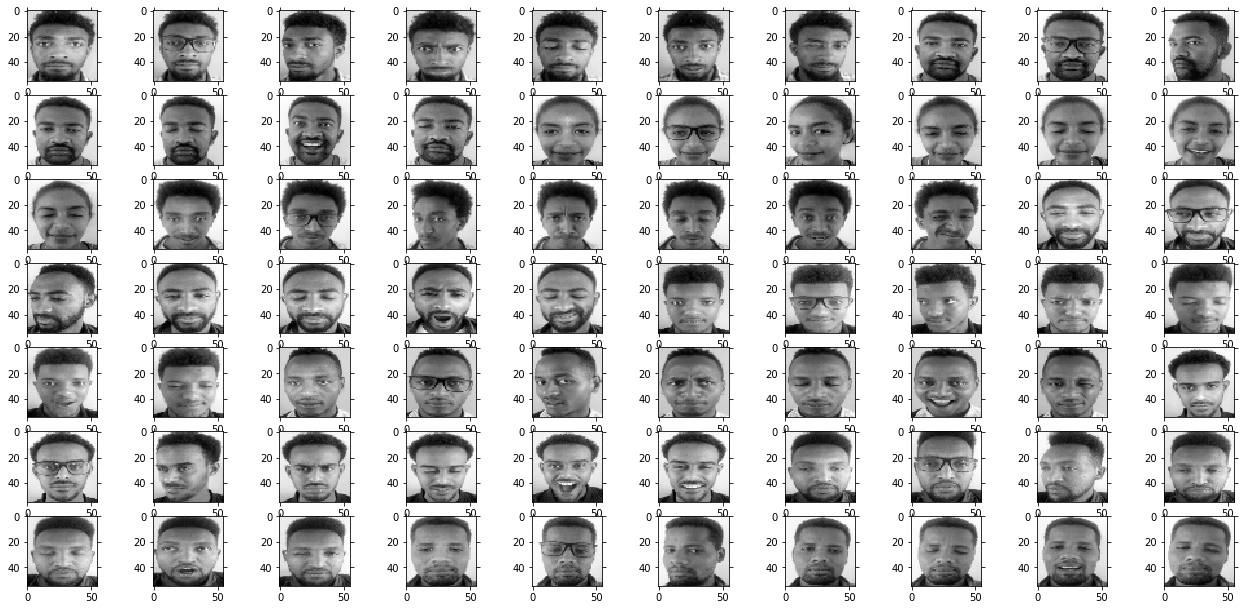

In [3]:
print('Train Images:')
train_image_names = train_dir
training_tensor   = np.ndarray(shape=(len(train_image_names),height*width), dtype=np.float64)
lst=[]
lstnoresize=[]
for i in range(len(train_image_names)):
    img = plt.imread(train_path + train_image_names[i])
    imresize=cv2.resize(img,(height,width)) 
    training_tensor[i,:] = np.array(imresize, dtype='float64').flatten()
    lst.append(imresize)
    plt.subplot(10,10,1+i)
    plt.imshow(imresize, cmap='gray')
    plt.subplots_adjust(right=3.0, top=3)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()
images=np.array(lst)

Test Images:


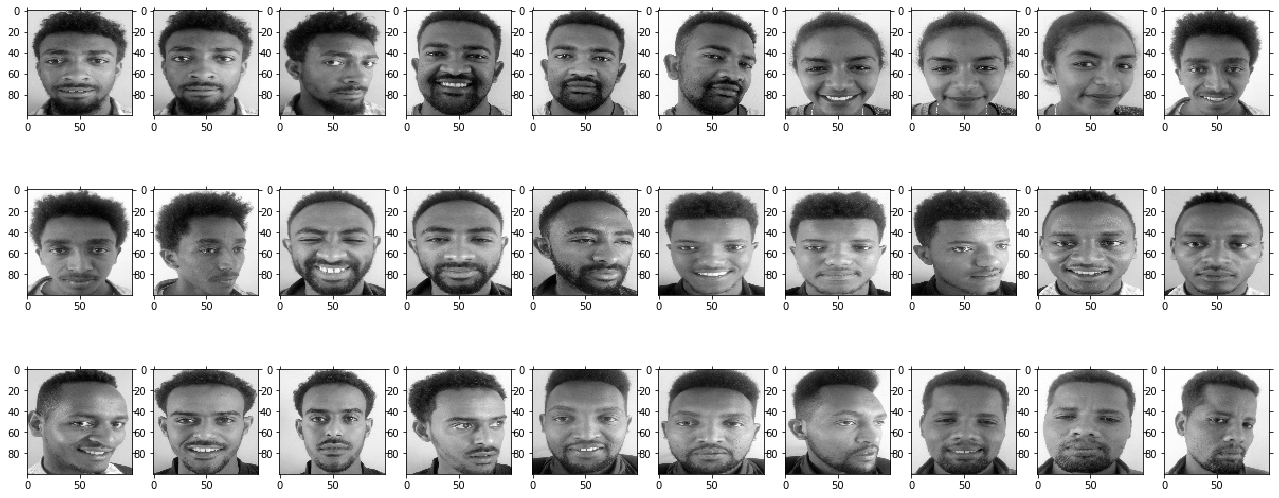

In [4]:
print('Test Images:')
test_image_names = test_dir
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(test_path + test_image_names[i])
    testresize=cv2.resize(img,(height,width))
    testing_tensor[i,:] = np.array(testresize, dtype='float64').flatten()
    plt.subplot(8,10,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=3.0, top=5)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

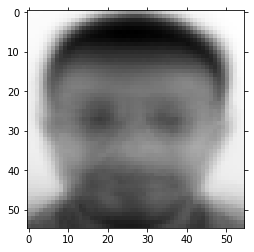

In [5]:
mean_face = np.zeros((1,height*width))
for i in training_tensor:
    mean_face = np.add(mean_face,i)
mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()
plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [6]:
def pca_model():
    img_vectors=np.reshape(images,(images.shape[0],images.shape[1]*images.shape[2])) 
    shortmean=np.mean(img_vectors,axis=0)
    image_std_vec=np.std(img_vectors,axis=0)
    normalized=[]
    for j in img_vectors:
        normalized.append((j-shortmean)) 
    normalized=np.array(normalized)
    covar=np.cov(np.transpose(normalized)) 
    eigvals, eigvects=np.linalg.eig(covar) 
    mean_face=np.reshape(shortmean,(images.shape[1]*images.shape[2]))
    idx = eigvals.argsort()[::-1]   
    eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    eig_vectors=np.real(np.transpose(eigvects))
    imp_eig_vectors=eig_vectors[:60] #taking only first 60 eigenvectors
    eig_vectors_pca=eig_vectors[3:13] 
    return [eigvals,eig_vectors,mean_face,imp_eig_vectors,img_vectors,eig_vectors_pca]

In [7]:
[eigvals,eig_vectors,mean_face,imp_eig_vectors,img_vectors,eig_vectors_pca] = pca_model()
d={'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[],'10':[]} #taking only 10 subjects for classification 
k=1 
while(k<11):
    for i in train_dir:
        if(k<=9):
            q='0'+str(k)
            if(i[4:6]==q):
                d[str(k)].append(i)
        else:
            q=k
            if(i[4:6]==str(q)):
                d[str(k)].append(i)
    k+=1

In [8]:
#Creating a X vector containing samples from each class. 
X=[d[i] for i in d.keys()]
tensor=[]
for i in range(0,10):
    for j in range(0,7):
        img = plt.imread(train_path + X[i][j])
        imresize=cv2.resize(img,(height,width)).flatten() 
        tensor.append(np.array(imresize, dtype='float64')) 
classes_data=[]
for i in range(0,70,7):
    classes_data.append(tensor[i:i+7]) 
classes_data_np=np.array(classes_data) 
classes_data_np.shape

(10, 7, 3025)

# Find the weights for each image

In [27]:
print(len(imp_eig_vectors))
weights=[] #Corresponds to the weights of images in each class
for i in range(0,10):
    class_weights=[] #weights per class
    for j in range(0,7):
        image_weights=[] #a list of weights per image
        for k in range(0,len(imp_eig_vectors)):
            projected_weight=np.dot(imp_eig_vectors[k],classes_data_np[i][j]) 
            image_weights.append(projected_weight)   
        class_weights.append(image_weights)
    weights.append(class_weights)
weights=np.array(weights)
# print(weights.shape[0])
print(weights.shape[2])
print(weights.shape)

60
60
(10, 7, 60)


# Calculate Sb and Sw

In [38]:
#the mean weights for each class
def Fishers_model():
    mean_weights_class=np.mean(weights,axis=1)
  
    #Calculating Sw Scatter matrix with-in class
    Sw=np.zeros((weights.shape[2],weights.shape[2]),dtype='float64')
    for i in range(0,len(weights)):
        for j in range(0,len(weights[i])):
            term1_sw=np.subtract(weights[i][j],
                                 mean_weights_class[i].reshape((1,mean_weights_class[0].shape[0]))).reshape(1,weights.shape[2])
            term2_sw=np.transpose(term1_sw)
            product_sw=np.matmul(term2_sw,term1_sw)
            Sw=Sw+product_sw
    Sw_inverse=np.linalg.inv(Sw)
     
    #Calculating Sb which is scatter matrix between class
    Sb=np.zeros((weights.shape[2],weights.shape[2]),dtype='float64')
    for i in range(0,len(mean_weights_class)):
        term1=np.subtract(mean_weights_class[i].reshape((1,mean_weights_class[0].shape[0])),
                          weights.reshape((weights.shape[0]*weights.shape[1],
                          weights.shape[2])).mean(axis=0)).reshape(1,weights.shape[2]) 
        term2=np.transpose(term1) 
        product=len(weights[i])*np.matmul(term2,term1) 
        Sb=Sb+product 
        
        
    BinvA=np.matmul(Sw_inverse,Sb)     
    #Compute the inverse matrix and get its eigenvectors and eigenvalues
    inv_eigval, inv_eigvec=np.linalg.eig(BinvA) 
    idx = inv_eigval.argsort()[::-1]  
    
    inv_eigval = inv_eigval[idx]
    inv_eigvec = inv_eigvec[:,idx]

    inv_eigvec=np.transpose(inv_eigvec) 
    
    return [inv_eigval,inv_eigvec]
# product,inv_eigval,inv_eigvec=Fishers_model()
# print(len(product))

# Obtaining Fisherfaces

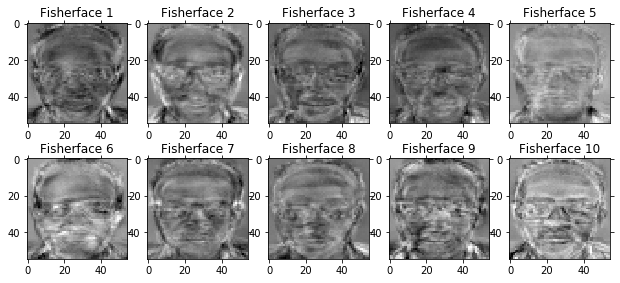

In [39]:
[inv_eigval,inv_eigvec] = Fishers_model()
plt.figure(figsize=(12,6))
for i in range(1,11,1):
    plt.subplot(2,5,i)
    plt.imshow(np.reshape(np.real(np.matmul(inv_eigvec[i-1],imp_eig_vectors)),(55,55)),cmap='gray')
    plt.title('Fisherface {}'.format(i))
    plt.subplots_adjust(right=0.8, top=0.7)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()
inv_eigvec=inv_eigvec[:10] 


# Get weights of training images using fisherfaces

In [12]:
all_imgs_w = np.reshape(weights,(-1,inv_eigvec.shape[-1])) 
train_coeffs = []
for i in range(len(all_imgs_w)):
    t = []
    for j in range(len(inv_eigvec)):
        t.append(np.dot(inv_eigvec[j],all_imgs_w[i])) 
    train_coeffs.append(t)
train_coeffs = np.array(train_coeffs)

# Getting coefficients for test images 

In [13]:
def get_coefficients():
    test_imgs=testing_tensor 
    test_pca_coeffs = []
    for i in range(len(test_imgs)):
        t = []
        for j in range(len(imp_eig_vectors)):
            t.append(np.dot(imp_eig_vectors[j],test_imgs[i]))
        test_pca_coeffs.append(t)
    test_pca_coeffs = np.array(test_pca_coeffs)
    lda_compute=test_pca_coeffs
    test_flda = []
    for i in range(len(lda_compute)):
        t = []
        for j in range(len(inv_eigvec)):
            t.append(np.dot(inv_eigvec[j],lda_compute[i]))
        test_flda.append(t)
    test_flda = np.array(test_flda)
    return [test_flda,test_imgs]


#  predictions by computing distance

In [14]:
[test_flda,test_imgs] =get_coefficients()
predict = []
for i in range(len(test_flda)):
    d = []
    for j in range(len(train_coeffs)):
        d.append(np.sum(np.square(test_flda[i]-train_coeffs[j])))
    d = np.array(d)
    predict.append(np.argmin(d))
print(predict)

[4, 2, 0, 11, 11, 66, 17, 17, 18, 21, 25, 24, 34, 31, 30, 40, 35, 38, 46, 48, 46, 55, 50, 55, 57, 61, 62, 66, 69, 66]


Compute accuracy of predictions of fishers

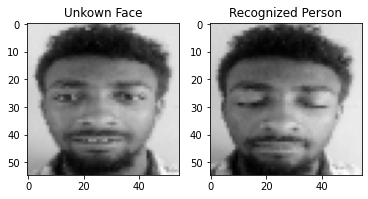

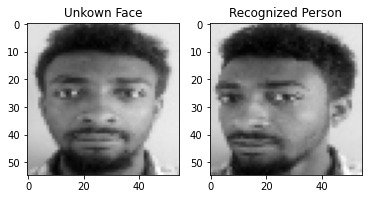

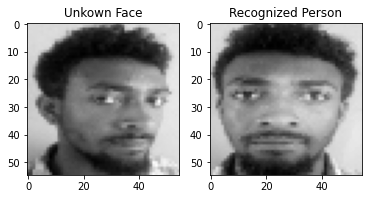

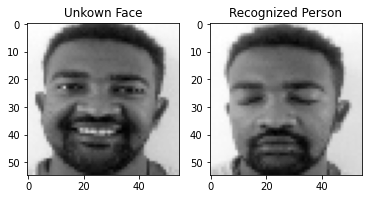

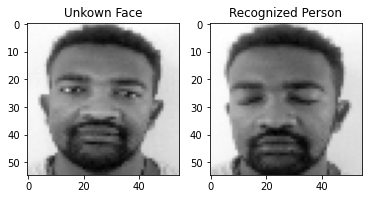

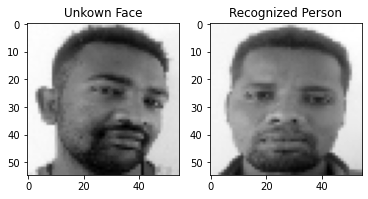

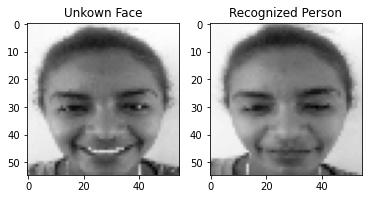

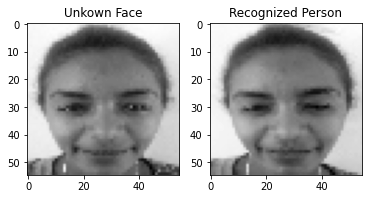

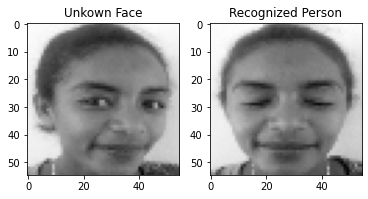

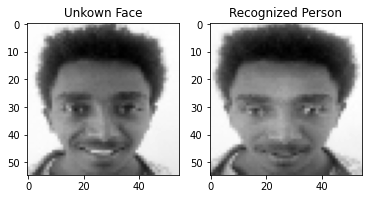

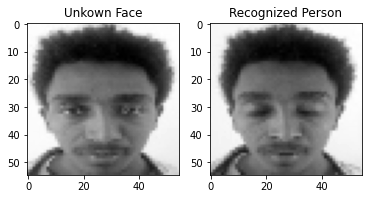

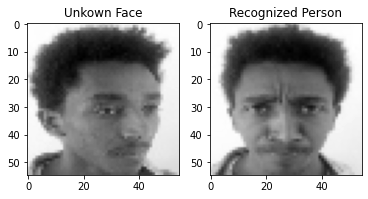

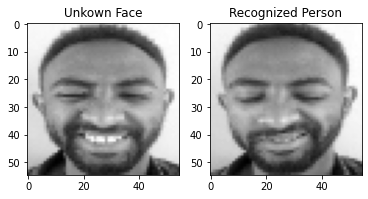

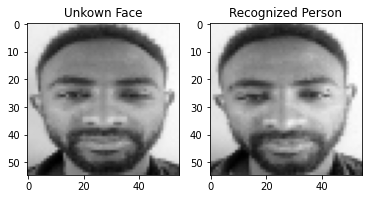

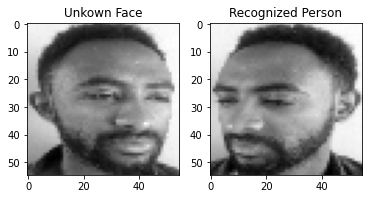

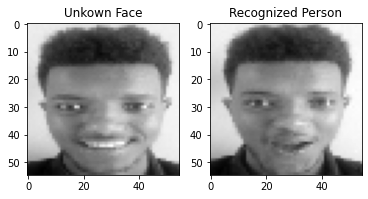

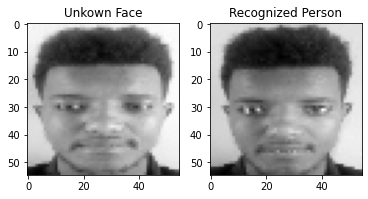

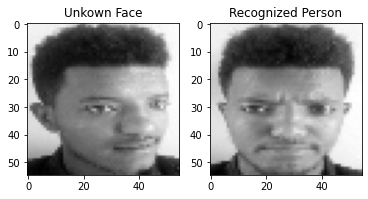

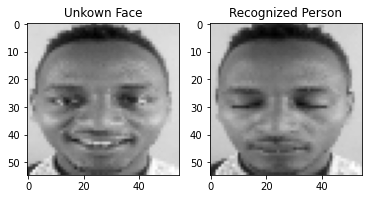

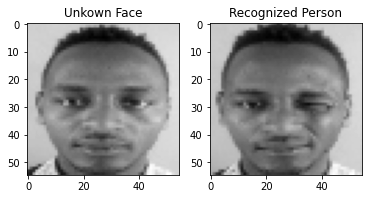

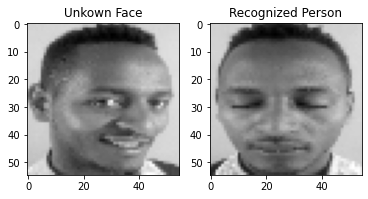

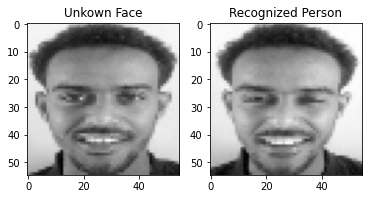

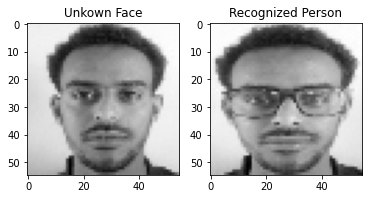

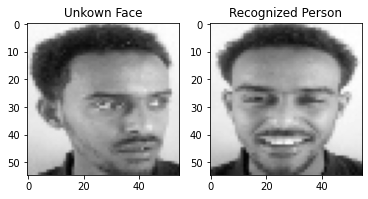

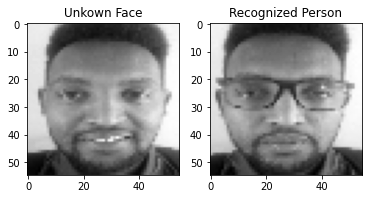

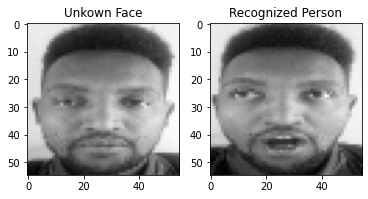

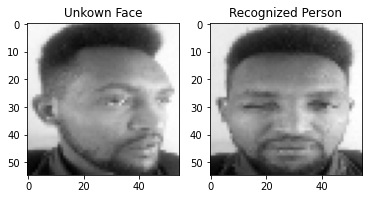

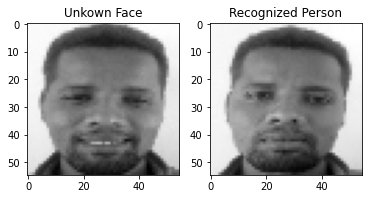

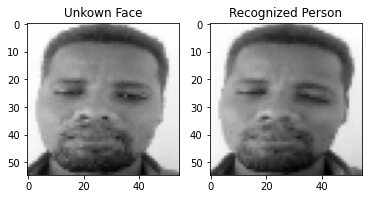

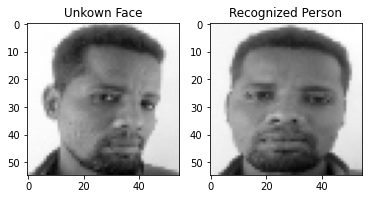

In [15]:
correct_match=0
total_length=0

for i in range(0,len(test_imgs)):

    plt.subplot(1,2,1)
    plt.imshow(test_imgs[i].reshape((height,width)),cmap='gray')
    plt.title('Unkown Face')
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(img_vectors[predict[i]],(height,width)),cmap='gray')
    plt.title('Recognized Person')
    plt.show()
    if(train_image_names[predict[i]].split(".")[0]==test_image_names[i].split(".")[0]):
        correct_match+=1
    total_length+=1


In [16]:
print("The accuracy using 10 Fisherfaces is ",(correct_match/total_length)*100)
t2_stop = time.time()
print("\nElapsed Time During  The Operation:",t2_stop-t2_start)

The accuracy using 10 Fisherfaces is  96.66666666666667

Elapsed Time During  The Operation: 56.196571826934814
